## Environment Setup

In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression

## Data Processing

In [2]:
# Load dataset
df = pd.read_csv('/Users/apple/Downloads/archive/SBAnational.csv')

df_copy = df.copy()

df_copy.info()

/Applications/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 899164 entries, 0 to 899163
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   LoanNr_ChkDgt      899164 non-null  int64  
 1   Name               899150 non-null  object 
 2   City               899134 non-null  object 
 3   State              899150 non-null  object 
 4   Zip                899164 non-null  int64  
 5   Bank               897605 non-null  object 
 6   BankState          897598 non-null  object 
 7   NAICS              899164 non-null  int64  
 8   ApprovalDate       899164 non-null  object 
 9   ApprovalFY         899164 non-null  object 
 10  Term               899164 non-null  int64  
 11  NoEmp              899164 non-null  int64  
 12  NewExist           899028 non-null  float64
 13  CreateJob          899164 non-null  int64  
 14  RetainedJob        899164 non-null  int64  
 15  FranchiseCode      899164 non-null  int64  
 16  Ur

In [3]:
# Check null values in the dataset
df_copy.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

We can see that *ChgOffDate* attribute has many null values. This is not a big concern, because we will not be using charged-off date in our model. However, we have to drop null values for some specified columns.

In [4]:
# Drop null values from specified columns
df_copy.dropna(subset=['Name', 'City', 'State', 'BankState', 'NewExist','RevLineCr', 'LowDoc', 'DisbursementDate', 'MIS_Status'], inplace=True)
df_copy.isnull().sum()

LoanNr_ChkDgt             0
Name                      0
City                      0
State                     0
Zip                       0
Bank                      0
BankState                 0
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                  0
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr                 0
LowDoc                    0
ChgOffDate           725369
DisbursementDate          0
DisbursementGross         0
BalanceGross              0
MIS_Status                0
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

In [5]:
# Remove '$', commas, and extra spaces from records in columns with dollar values that should be floats
df_copy[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']] = \
df_copy[['DisbursementGross', 'BalanceGross', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv']].applymap(lambda x: x.strip().replace('$', '').replace(',', ''))

In [6]:
# Check data types of each feature
df_copy.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                    int64
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY            object
Term                   int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross     object
BalanceGross          object
MIS_Status            object
ChgOffPrinGr          object
GrAppv                object
SBA_Appv              object
dtype: object

In [7]:
# Create a function to apply formatting to the records of str type only
def clean_str(x):
    if isinstance(x, str):
        return x.replace('A', '')
    return x


df_copy['ApprovalFY'] = df_copy['ApprovalFY'].apply(clean_str).astype('int64')

In [8]:
# Change the type of NewExist to an integer, Zip and UrbanRural to str (categorical) and all currency-related fields to float values
df_copy = df_copy.astype({'Zip': 'str', 'NewExist': 'int64', 'UrbanRural': 'str', 'DisbursementGross': 'float', 'BalanceGross': 'float',
                          'ChgOffPrinGr': 'float', 'GrAppv': 'float', 'SBA_Appv': 'float'})

# Check to see dtypes again
df_copy.dtypes

LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Zip                   object
Bank                  object
BankState             object
NAICS                  int64
ApprovalDate          object
ApprovalFY             int64
Term                   int64
NoEmp                  int64
NewExist               int64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural            object
RevLineCr             object
LowDoc                object
ChgOffDate            object
DisbursementDate      object
DisbursementGross    float64
BalanceGross         float64
MIS_Status            object
ChgOffPrinGr         float64
GrAppv               float64
SBA_Appv             float64
dtype: object

In [9]:
# Create a new column with the industry the NAICS code represents
# Selects only the first two numbers of the NAICS code
df_copy['Industry'] = df_copy['NAICS'].astype('str').apply(lambda x: x[:2])

# Maps the approprate industry to each record based on the first two digits of the NAICS code
df_copy['Industry'] = df_copy['Industry'].map({
    '11': 'Ag/For/Fish/Hunt',
    '21': 'Min/Quar/Oil_Gas_ext',
    '22': 'Utilities',
    '23': 'Construction',
    '31': 'Manufacturing',
    '32': 'Manufacturing',
    '33': 'Manufacturing',
    '42': 'Wholesale_trade',
    '44': 'Retail_trade',
    '45': 'Retail_trade',
    '48': 'Trans/Ware',
    '49': 'Trans/Ware',
    '51': 'Information',
    '52': 'Finance/Insurance',
    '53': 'RE/Rental/Lease',
    '54': 'Prof/Science/Tech',
    '55': 'Mgmt_comp',
    '56': 'Admin_sup/Waste_Mgmt_Rem',
    '61': 'Educational',
    '62': 'Healthcare/Social_assist',
    '71': 'Arts/Entertain/Rec',
    '72': 'Accom/Food_serv',
    '81': 'Other_no_pub',
    '92': 'Public_Admin'
})

# Remove records where Industry is NaN (NAICS code was a 0)
df_copy.dropna(subset=['Industry'], inplace=True)

In [10]:
# Create flag column IsFranchise based on FranchiseCode column
df_copy.loc[(df_copy['FranchiseCode'] <= 1), 'IsFranchise'] = 0
df_copy.loc[(df_copy['FranchiseCode'] > 1), 'IsFranchise'] = 1

In [11]:
# NewExist
# Makesure NewExist has only 1s and 2s; Remove records where NewExist isn't 1 or 2
df_copy['NewExist'].unique()

array([2, 1, 0])

In [12]:
# Keep records where NewExist == 1 or 2
df_copy = df_copy[(df_copy['NewExist'] == 1) | (df_copy['NewExist'] == 2)]

# Create NewBusiness field where 0 = Existing business and 1 = New business; based on NewExist field
df_copy.loc[(df_copy['NewExist'] == 1), 'NewBusiness'] = 0
df_copy.loc[(df_copy['NewExist'] == 2), 'NewBusiness'] = 1

In [13]:
# RevLineCr and LowDoc
# Double check RevLineCr and LowDoc unique values
df_copy['RevLineCr'].unique()

array(['N', 'Y', '0', 'T', '`', ',', '1', 'C', '2', 'R', '7', 'A', '-',
       'Q'], dtype=object)

In [14]:
df_copy['LowDoc'].unique()

array(['Y', 'N', 'C', '1', 'S', 'R', 'A', '0'], dtype=object)

In [15]:
# Remove records where RevLineCr != 'Y' or 'N' and LowDoc != 'Y' or 'N'
df_copy = df_copy[(df_copy['RevLineCr'] == 'Y') | (df_copy['RevLineCr'] == 'N')]
df_copy = df_copy[(df_copy['LowDoc'] == 'Y') | (df_copy['LowDoc'] == 'N')]

# RevLineCr and LowDoc: 0 = No, 1 = Yes
df_copy['RevLineCr'] = np.where(df_copy['RevLineCr'] == 'N', 0, 1)
df_copy['LowDoc'] = np.where(df_copy['LowDoc'] == 'N', 0, 1)

# Check that it worked
print(df_copy['RevLineCr'].unique())
print(df_copy['LowDoc'].unique())

[0 1]
[1 0]


In [16]:
# MIS_Status
# Make Default target field based on MIS_Status where P I F = 0 and CHGOFF = 1 so we can see what features are prevalant in a defaulted loan
df_copy['Default'] = np.where(df_copy['MIS_Status'] == 'P I F', 0, 1)
df_copy['Default'].value_counts()

0    358558
1     98382
Name: Default, dtype: int64

In [17]:
# Convert ApprovalDate and DisbursementDate columns to datetime values
# ChgOffDate not changed to datetime since it is not of value and will be removed later
df_copy[['ApprovalDate', 'DisbursementDate']] = df_copy[['ApprovalDate', 'DisbursementDate']].apply(pd.to_datetime)

In [18]:
# Create DaysToDisbursement column which calculates the number of days passed between DisbursementDate and ApprovalDate
df_copy['DaysToDisbursement'] = df_copy['DisbursementDate'] - df_copy['ApprovalDate']

# Change DaysToDisbursement from a timedelta64 dtype to an int64 dtype
# Converts series to str, removes all characters after the space before 'd' in days for each record, then changes the dtype to int
df_copy['DaysToDisbursement'] = df_copy['DaysToDisbursement'].astype('str').apply(lambda x: x[:x.index('d') - 1]).astype('int64')

In [19]:
# Create DisbursementFY field for time selection criteria later
df_copy['DisbursementFY'] = df_copy['DisbursementDate'].map(lambda x: x.year)

In [20]:
# Create StateSame flag field which identifies where the business State is the same as the BankState
df_copy['StateSame'] = np.where(df_copy['State'] == df_copy['BankState'], 1, 0)

In [21]:
# Create SBA_AppvPct field since the guaranteed amount is based on a percentage of the gross loan amount rather than dollar amount in most situations
df_copy['SBA_AppvPct'] = df_copy['SBA_Appv'] / df_copy['GrAppv']

In [22]:
# Create AppvDisbursed flag field signifying if the loan amount disbursed was equal to the full amount approved
df_copy['AppvDisbursed'] = np.where(df_copy['DisbursementGross'] == df_copy['GrAppv'], 1, 0)

In [23]:
df_copy.dtypes

LoanNr_ChkDgt                  int64
Name                          object
City                          object
State                         object
Zip                           object
Bank                          object
BankState                     object
NAICS                          int64
ApprovalDate          datetime64[ns]
ApprovalFY                     int64
Term                           int64
NoEmp                          int64
NewExist                       int64
CreateJob                      int64
RetainedJob                    int64
FranchiseCode                  int64
UrbanRural                    object
RevLineCr                      int64
LowDoc                         int64
ChgOffDate                    object
DisbursementDate      datetime64[ns]
DisbursementGross            float64
BalanceGross                 float64
MIS_Status                    object
ChgOffPrinGr                 float64
GrAppv                       float64
SBA_Appv                     float64
I

In [24]:
# Format dtypes where necessary after feature engineering
df_copy = df_copy.astype({'IsFranchise': 'int64', 'NewBusiness': 'int64'})
df_copy.dtypes

LoanNr_ChkDgt                  int64
Name                          object
City                          object
State                         object
Zip                           object
Bank                          object
BankState                     object
NAICS                          int64
ApprovalDate          datetime64[ns]
ApprovalFY                     int64
Term                           int64
NoEmp                          int64
NewExist                       int64
CreateJob                      int64
RetainedJob                    int64
FranchiseCode                  int64
UrbanRural                    object
RevLineCr                      int64
LowDoc                         int64
ChgOffDate                    object
DisbursementDate      datetime64[ns]
DisbursementGross            float64
BalanceGross                 float64
MIS_Status                    object
ChgOffPrinGr                 float64
GrAppv                       float64
SBA_Appv                     float64
I

Now that each field we care about appears to have the correct data type, we can remove the fields that won't provide much value to the analysis. These are as follows:

+ LoanNr_ChkDgt and Name - provides no value to the actual analysis

+ City and Zip - each have a large number of unique values, and my assumption is that it is not likely either would have any particularly significant values

+ Bank - Name of the bank shouldn't matter for analysis, however this could potentially be used when revisiting this analysis to determine the asset size of the bank servicing the loan

+ ChgOffDate - only applies when a loan is charged off and isn't relevant to the analysis

+ NAICS - replaced by Industry

+ NewExist - replaced by NewBusiness flag field

+ FranchiseCode - replaced by IsFranchise flag field

+ ApprovalDate and DisbursementDate - hypothesis that DaysToDisbursement will be more valueable

+ SBA_Appv - guaranteed amount is based on percentage of gross loan amount, not dollar amount typically

+ MIS_Status - Default field replaces this as the target field

In [25]:
df_copy.drop(columns=['LoanNr_ChkDgt', 'Name', 'City', 'Zip', 'Bank', 'NAICS', 'ApprovalDate', 'NewExist', 'FranchiseCode',
                      'ChgOffDate', 'DisbursementDate', 'BalanceGross', 'ChgOffPrinGr', 'SBA_Appv', 'MIS_Status'], inplace=True)

In [26]:
# Verify all null values are removed from data
df_copy.isnull().sum()

State                 0
BankState             0
ApprovalFY            0
Term                  0
NoEmp                 0
CreateJob             0
RetainedJob           0
UrbanRural            0
RevLineCr             0
LowDoc                0
DisbursementGross     0
GrAppv                0
Industry              0
IsFranchise           0
NewBusiness           0
Default               0
DaysToDisbursement    0
DisbursementFY        0
StateSame             0
SBA_AppvPct           0
AppvDisbursed         0
dtype: int64

In [27]:
# Check the shape of the data as it stands
df_copy.shape

(456940, 21)

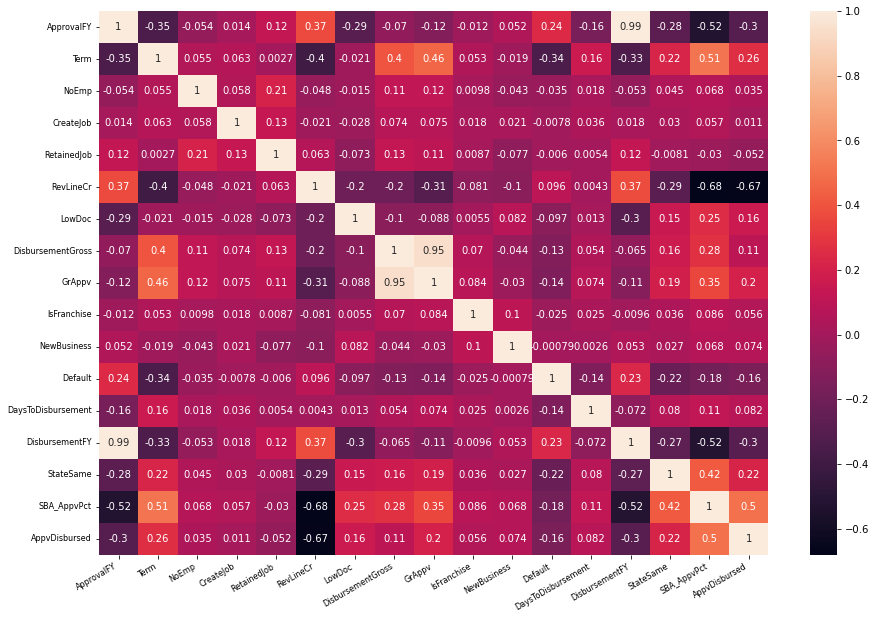

In [28]:
# Correlation Matrix
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
corr_matrix = df_copy.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=8)
plt.yticks(fontsize=8)

plt.show()

## Build Model

In [29]:
# One-hot encode categorical data
df_copy = pd.get_dummies(df_copy)

df_copy.head()

,ApprovalFY,Term,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,DisbursementGross,GrAppv,IsFranchise,...,Industry_Mgmt_comp,Industry_Min/Quar/Oil_Gas_ext,Industry_Other_no_pub,Industry_Prof/Science/Tech,Industry_Public_Admin,Industry_RE/Rental/Lease,Industry_Retail_trade,Industry_Trans/Ware,Industry_Utilities,Industry_Wholesale_trade
0,1997,84,4,0,0,0,1,60000.0,60000.0,0,...,0,0,0,0,0,0,1,0,0,0
1,1997,60,2,0,0,0,1,40000.0,40000.0,0,...,0,0,0,0,0,0,0,0,0,0
2,1997,180,7,0,0,0,0,287000.0,287000.0,0,...,0,0,0,0,0,0,0,0,0,0
5,1997,120,19,0,0,0,0,517000.0,517000.0,0,...,0,0,0,0,0,0,0,0,0,0
7,1997,84,1,0,0,0,1,45000.0,45000.0,0,...,0,0,1,0,0,0,0,0,0,0


In [30]:
# Establish target and feature fields
y = df_copy['Default']
X = df_copy.drop('Default', axis=1)

# Scale the feature values prior to modeling
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.25)

In [31]:
# Initialize model
log_reg = LogisticRegression(random_state=2)

# Train the model and make predictions
log_reg.fit(X_train, y_train)
y_logpred = log_reg.predict(X_val)

# Print the results
print(classification_report(y_val, y_logpred, digits=3))

              precision    recall  f1-score   support

           0      0.887     0.954     0.919     89666
           1      0.769     0.556     0.646     24569

    accuracy                          0.869    114235
   macro avg      0.828     0.755     0.783    114235
weighted avg      0.862     0.869     0.861    114235

